# *Monod* on Colab

In the current notebook, we apply *Monod* to identify differentially regulated genes between GABAergic and glutamatergic cell types in a single Allen dataset.

# Inference pipeline

## Install prerequisites

In [1]:
# #Install Monod package which contains the meK-Means method
# !pip install monod

!git clone https://github.com/pachterlab/monod.git

%cd /content/monod
!git checkout anndata

Cloning into 'monod'...
remote: Enumerating objects: 1783, done.
remote: Counting objects: 100% (355/355), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 1783 (delta 216), reused 212 (delta 128), pack-reused 1428 (from 1)
Receiving objects: 100% (1783/1783), 29.42 MiB | 5.89 MiB/s, done.
Resolving deltas: 100% (1026/1026), done.
/content/monod
Updating files: 100% (14/14), done.
Branch 'anndata' set up to track remote branch 'anndata' from 'origin'.
Switched to a new branch 'anndata'


In [2]:
!pip install -q ./
!pip install -q -r /content/monod/src/monod.egg-info/requires.txt

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 58.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 2.7 MB/s eta 0:00:00


In [6]:
! pip install scanpy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 7.0 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=dcba5a1dfd713ce68a613e9ea9cf392b0b6359df06621ce80546f72b4b72691a
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [7]:
import sys
import scanpy
sys.path.insert(0, '/content/monod/src/monod')
import extract_data, cme_toolbox, inference, analysis, mminference

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import anndata
from IPython.display import display, Markdown
import scanpy as sc
import anndata as ad
import numpy as np
import os
import zlib
import math
import argparse
from pathlib import Path

In [16]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore") #warning suppression within script is not respected by colab
warnings.simplefilter('ignore')

Let's make sure that the version is correct.

## Import data

In [20]:
%cd /content

! git clone https://github.com/pachterlab/monod_examples.git

%cd /content/monod_examples
!git checkout anndata

/content
fatal: destination path 'monod_examples' already exists and is not an empty directory.
/content/monod_examples
Already on 'anndata'
Your branch is up to date with 'origin/anndata'.


In [15]:
def decompress_chunk(compressed_data):
    """Decompress a zlib-compressed bytes object"""
    return zlib.decompress(compressed_data)

def combine_chunks(input_dir, output_file):
    """Combine compressed chunks back into a single h5ad file"""
    # Get all chunk files sorted by name
    chunk_files = sorted(Path(input_dir).glob('chunk_*.gz'))

    # Combine chunks
    combined_data = bytes()
    for chunk_file in chunk_files:
        with open(chunk_file, 'rb') as f:
            compressed_chunk = f.read()
        chunk = decompress_chunk(compressed_chunk)
        combined_data += chunk
        print(f'Processed chunk: {chunk_file}')

    # Write combined data to temporary file
    with open('temp_combined.h5ad', 'wb') as f:
        f.write(combined_data)

    # Load and save as AnnData to ensure proper format
    adata = ad.read_h5ad('temp_combined.h5ad')
    adata.write(output_file)#, compression='gzip')

    # Clean up temporary file
    os.remove('temp_combined.h5ad')
    print(f'Successfully created combined file: {output_file}')

In [22]:
%cd /content

combine_chunks('/content/monod_examples/sample_data/gaba_anndata', 'gaba_example.h5ad')
combine_chunks('/content/monod_examples/sample_data/glu_anndata', 'glu_example.h5ad')

/content
Processed chunk: /content/monod_examples/sample_data/glu_anndata/chunk_0000.gz
Processed chunk: /content/monod_examples/sample_data/glu_anndata/chunk_0001.gz
Processed chunk: /content/monod_examples/sample_data/glu_anndata/chunk_0002.gz
Processed chunk: /content/monod_examples/sample_data/glu_anndata/chunk_0003.gz
Processed chunk: /content/monod_examples/sample_data/glu_anndata/chunk_0004.gz
Processed chunk: /content/monod_examples/sample_data/glu_anndata/chunk_0005.gz
Processed chunk: /content/monod_examples/sample_data/glu_anndata/chunk_0006.gz
Processed chunk: /content/monod_examples/sample_data/glu_anndata/chunk_0007.gz
Processed chunk: /content/monod_examples/sample_data/glu_anndata/chunk_0008.gz
Processed chunk: /content/monod_examples/sample_data/glu_anndata/chunk_0009.gz


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Successfully created combined file: glu_example.h5ad


### Load data and filter if desired

In [15]:
glu_adata = anndata.read_h5ad('./glu_example.h5ad')

/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [24]:
gaba_adata = anndata.read_h5ad('./gaba_example.h5ad')

# # N.B. The adata should have var_names as gene names which match the transcriptome.
# try:
#     gene_names = gaba_adata.var['gene_name'].astype(str)
#     gaba_adata.var_names = gene_names
# except:
#     pass

# gaba_adata.var_names_make_unique()

/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Create knee plot.

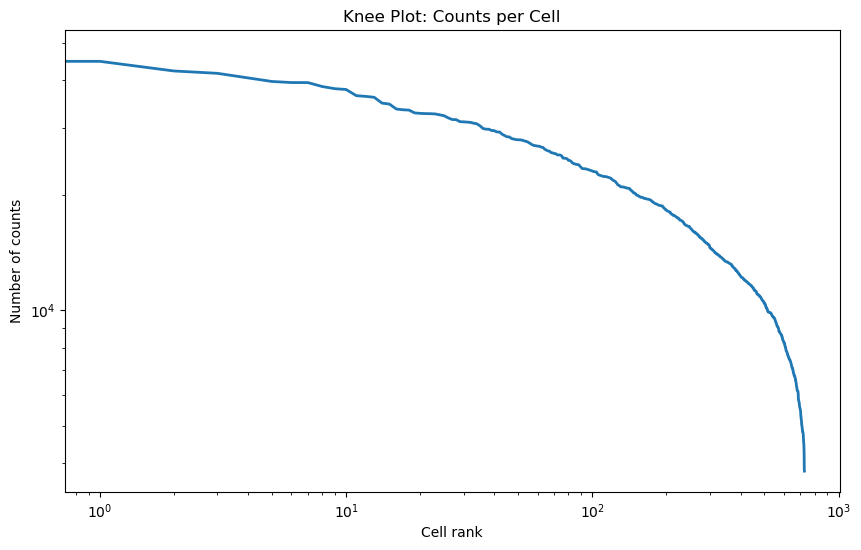

In [ ]:
# Calculate number of genes per cell
sc.pp.calculate_qc_metrics(gaba_adata, inplace=True)

# Sort cells by number of genes
total_counts = np.sort(gaba_adata.obs.total_counts)[::-1]

# Create range for x-axis
cell_range = range(len(total_counts))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(cell_range, total_counts, linewidth=2)

plt.xlabel('Cell rank')
plt.ylabel('Number of counts')
plt.title('Knee Plot: Counts per Cell')

# Add log scales
plt.xscale('log')
plt.yscale('log')

plt.show()

Filter by number of counts if desired.

In [ ]:
threshold = 10
sc.pp.filter_cells(gaba_adata, min_counts=threshold)

Combine mature and ambiguous layers into a spliced layer if necessary.

In [ ]:
# # Check if required layers exist
# if 'mature' not in gaba_adata.layers or 'ambiguous' not in gaba_adata.layers:
#     raise ValueError("Both 'mature' and 'ambiguous' layers must exist in the AnnData object")

# # Sum the layers
# gaba_adata.layers['spliced'] = gaba_adata.layers['mature'] + gaba_adata.layers['ambiguous']

## Set up model and perform inference.

Optional Fit Parameters

In [8]:
transcriptome_filepath =  './monod_examples/polyA_ref/gg_200524_mouse_genome_polyA_cum_1'
demo_genes = ['Eif5b','Xrcc5','Klhl12','Rgs7','Thsd7b']
lb, ub, samp_lb, samp_ub, gridsize = None, None, None, None, None # Can add as keywords if desired.

The expected modalities for this model are: ['unspliced', 'spliced']
If your anndata layers have different names, please give a modality dictionary of the form: modality_name_dict  = {'spliced':your_spliced_layer_name, 'unspliced':your_unspliced_layer_name} 
INFO:root:No dataset name given (dataset_string=None). Saving as Bursty_Poisson
INFO:root:Directory Bursty_Poisson already exists.
INFO:root:Beginning data extraction.
INFO:root:Dataset: Bursty_Poisson
INFO:root:Using default gene filtering parameters


/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names 

is sparse
INFO:root:Added lengths


/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


INFO:root:728 cells detected.


/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


3579 genes retained after expression filter.
INFO:root:Number of enforced genes: 5
INFO:root:0 random genes selected.
INFO:root:Total of 5 genes selected.
INFO:root:Data extracted
INFO:root:Search data created.
INFO:root:Directory Bursty_Poisson/Bursty_Poisson_6x7 already exists.
INFO:root:Global inference parameters stored to Bursty_Poisson/Bursty_Poisson_6x7/parameters.pr.
INFO:root:Global inference parameters set.
INFO:root:Starting parallelized grid scan.


100%|█████████████████████████████████| 42/42 [00:02<00:00, 18.23it/s]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory Bursty_Poisson/Bursty_Poisson_6x7/analysis_figures already exists.
INFO:root:Grid scan results stored to Bursty_Poisson/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:Runtime: 2.5 seconds.
INFO:root:Grid points fit.
INFO:root:Optimal parameters found.
INFO:root:Optimal parameters saved to anndata, under .var attributes in the form: "$\gamma$". Note that the parameters are given in log-base 10.
INFO:root:AIC values calculated and saved under .var attribute: AIC.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.


INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Standard error of the MLE computation complete. Runtime: 1.6 seconds.
INFO:root:Uncertainties per gene calculated, saved to anndata in .var attribute of the form: "error_$\gamma$". Note that the errors are given in log-base 10.


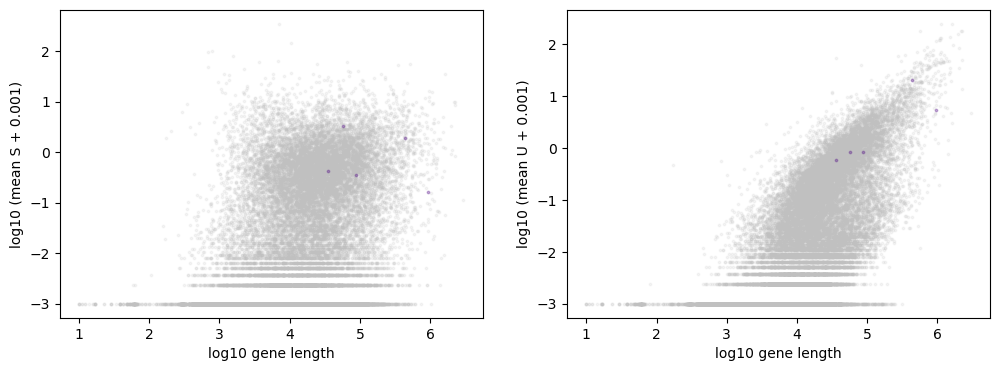

In [25]:
# Define model.
fitmodel = cme_toolbox.CMEModel('Bursty','Poisson')

# Define number of clusters and epochs if using meK-Means, otherwise set to None.
mek_means_params = None # (4,2)

gaba_adata = inference.perform_inference(gaba_adata, fitmodel, genes_to_fit=demo_genes,
                                         transcriptome_filepath=transcriptome_filepath,
                                         num_cores=16, mek_means_params=mek_means_params, n_genes=2)

INFO:root:Directory glu_example already exists.
INFO:root:Beginning data extraction.
INFO:root:Dataset: glu_example
INFO:root:Using default gene filtering parameters
INFO:root:Duplicate variable names found. Making them unique...
is sparse
INFO:root:Added lengths
INFO:root:6629 cells detected.
5520 genes retained after expression filter.
INFO:root:Number of enforced genes: 5
INFO:root:0 random genes selected.
INFO:root:Total of 5 genes selected.
INFO:root:Data extracted
INFO:root:Search data created.
INFO:root:Directory glu_example/Bursty_Poisson_6x7 already exists.
INFO:root:Global inference parameters stored to glu_example/Bursty_Poisson_6x7/parameters.pr.
INFO:root:Global inference parameters set.
INFO:root:Starting parallelized grid scan.


100%|█████████████████████████████████| 42/42 [00:02<00:00, 14.07it/s]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory glu_example/Bursty_Poisson_6x7/analysis_figures already exists.
INFO:root:Grid scan results stored to glu_example/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:Runtime: 3.4 seconds.
INFO:root:Grid points fit.
INFO:root:Optimal parameters found.
INFO:root:Optimal parameters saved to anndata, under .var attributes in the form: "$\gamma$". Note that the parameters are given in log-base 10.
INFO:root:AIC values calculated and saved under .var attribute: AIC.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.


INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Standard error of the MLE computation complete. Runtime: 1.7 seconds.
INFO:root:Uncertainties per gene calculated, saved to anndata in .var attribute of the form: "error_$\gamma$". Note that the errors are given in log-base 10.


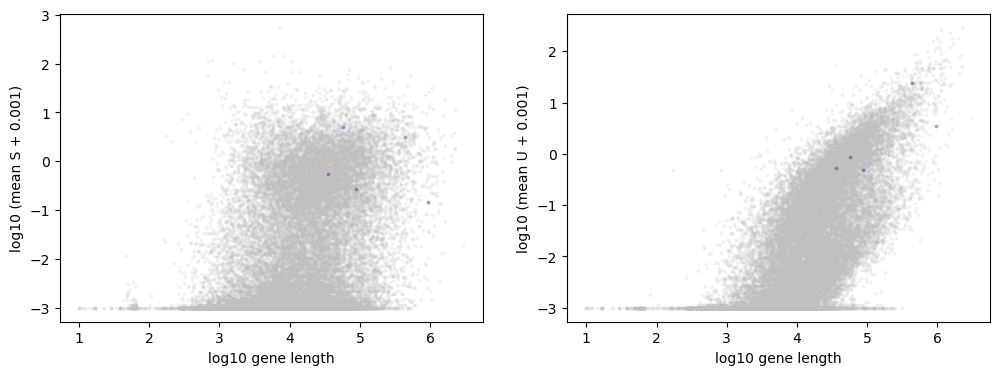

In [17]:
# Fix the genes to be the same as for the gaba data.
genes_to_fit = [i for i in gaba_adata.var_names]
n_genes = len(genes_to_fit)

glu_adata = inference.perform_inference('./glu_example.h5ad', fitmodel, n_genes=n_genes, genes_to_fit=genes_to_fit,
                transcriptome_filepath=transcriptome_filepath, mek_means_params=mek_means_params, num_cores=16)

## Access gene info.

In [10]:
# AIC.
display(gaba_adata.var[['AIC']])

# Optimum biological parameters and associated errors.
display(gaba_adata.var[[i for i in gaba_adata.var.keys() if '$' in i]])

,AIC
gene_name,
Eif5b,5073.598870
Xrcc5,2900.436196
Klhl12,2826.160827
Rgs7,8317.433133
Thsd7b,4417.919920


,$b$,$\beta$,$\gamma$,error_$b$,error_$\beta$,error_$\gamma$
gene_name,,,,,,
Eif5b,1.172837,-0.175999,-0.341383,0.045045,0.044166,0.044646
Xrcc5,1.374600,0.205610,0.819411,0.050675,0.043932,0.054704
Klhl12,1.165874,-0.251265,0.527014,0.080235,0.077213,0.082205
Rgs7,1.709504,-0.167372,0.426100,0.026477,0.022899,0.027416
Thsd7b,1.278203,0.309665,1.070020,0.036484,0.026823,0.052046


In [18]:
# AIC.
display(glu_adata.var[['AIC']])

# Optimum biological parameters and associated errors.
display(glu_adata.var[[i for i in glu_adata.var.keys() if '$' in i]])

,AIC
gene_name,
Eif5b,50406.627448
Xrcc5,21098.899156
Klhl12,26314.937293
Rgs7,81175.388161
Thsd7b,33819.385672


,$b$,$\beta$,$\gamma$,error_$b$,error_$\beta$,error_$\gamma$
gene_name,,,,,,
Eif5b,3.104042,-0.081362,-0.602127,0.013306,0.013094,0.013258
Xrcc5,2.740959,0.006486,0.303526,0.024510,0.023428,0.025630
Klhl12,2.844692,-0.323647,0.106713,0.029461,0.028870,0.029812
Rgs7,3.396659,-0.352569,-0.094628,0.008524,0.007762,0.008850
Thsd7b,3.005549,0.432836,0.862562,0.013166,0.009411,0.017552


## Plot parameter distributions.

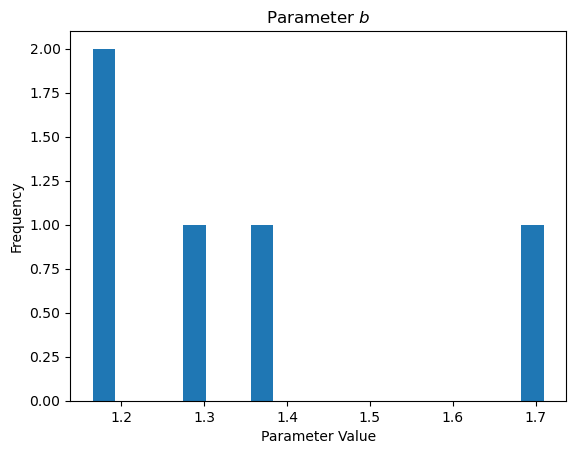

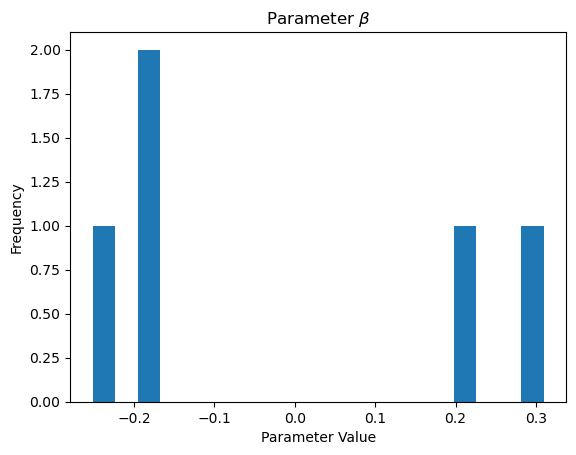

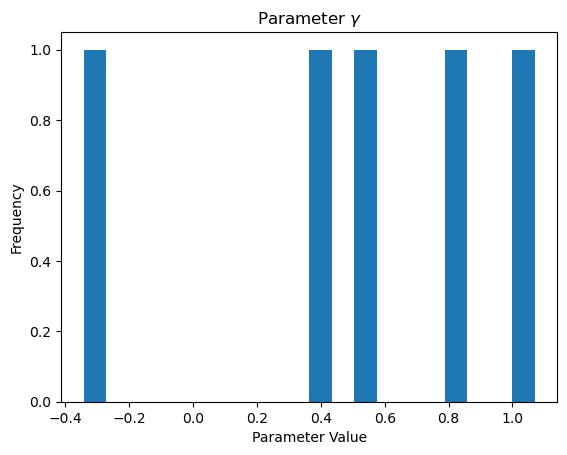

In [12]:
param_names = [i for i in gaba_adata.var.keys() if '$' in i and 'error' not in i]
for name in param_names:
    plt.hist(gaba_adata.var[name], bins=20)
    plt.title('Parameter ' + name)
    plt.xlabel('Parameter Value')
    plt.ylabel('Frequency')
    # plt.savefig(search_result.inference_string + '/parameter_dist_'+ str(i))#'/parameter_dist_{}'.format(
    plt.show()

# Analysis

## Reject genes.

In [20]:
# # Add rejection filter to adata.
gaba_adata = inference.reject_genes(gaba_adata, reject_at_bounds=False, mek_means=mek_means_params, save_csq=True)#, threshold=-1, use_hellinger=False, reject_at_bounds=False)
glu_adata = inference.reject_genes(glu_adata, reject_at_bounds=False, mek_means=mek_means_params, save_csq=True)#, threshold=-1, use_hellinger=False, reject_at_bounds=False)

# Show rejected genes.
display(glu_adata.var[[i for i in glu_adata.var.keys() if 'rejected' in i]])
display(gaba_adata.var[[i for i in gaba_adata.var.keys() if 'rejected' in i]])

# Show chi-squared values, and other rejection statistics if saved.
display(glu_adata.var[[i for i in glu_adata.var.keys() if 'csq' in i or 'pval' in i or 'hellinger' in i]])
display(gaba_adata.var[[i for i in gaba_adata.var.keys() if 'csq' in i or 'pval' in i or 'hellinger' in i]])

# # # Save chi-square values.
# chi_squareds_glu,  chi_squareds_gaba = glu_adata.var['csq'], gaba_adata.var['csq']

INFO:root:P-value threshold: 0.05, Adjusted P-value threshold:0.05, Hellinger Threshold:0.05
INFO:root:Chi-square computation complete. Rejected 2 genes out of 5. Runtime: 0.0 seconds.
INFO:root:Chi-squared values for each gene have been added as "csq" in .var
INFO:root:P-values for each gene have been added as "pval" in .var
INFO:root:Hellinger distances for each gene have been added as "hellinger" in .var
INFO:root:Rejected genes are recorded in "rejected_genes" in .var
INFO:root:P-value threshold: 0.05, Adjusted P-value threshold:0.05, Hellinger Threshold:0.05
INFO:root:Chi-square computation complete. Rejected 1 genes out of 5. Runtime: 0.0 seconds.
INFO:root:Chi-squared values for each gene have been added as "csq" in .var
INFO:root:P-values for each gene have been added as "pval" in .var
INFO:root:Hellinger distances for each gene have been added as "hellinger" in .var
INFO:root:Rejected genes are recorded in "rejected_genes" in .var


,rejected_genes
gene_name,
Eif5b,False
Xrcc5,False
Klhl12,False
Rgs7,True
Thsd7b,False


,rejected_genes
gene_name,
Eif5b,False
Xrcc5,False
Klhl12,False
Rgs7,True
Thsd7b,True


,csq,pval,hellinger
gene_name,,,
Eif5b,231.436445,1.014325e-15,0.011614
Xrcc5,131.019168,4.068883e-20,0.004970
Klhl12,164.884998,2.837600e-25,0.006302
Rgs7,1092.448433,3.682223e-67,0.055711
Thsd7b,469.459289,6.853764e-61,0.018261


,csq,pval,hellinger
gene_name,,,
Eif5b,57.211714,4.003819e-03,0.034285
Xrcc5,21.348384,4.550581e-02,0.023882
Klhl12,25.756598,4.081714e-03,0.018318
Rgs7,250.500266,7.506307e-22,0.225944
Thsd7b,82.314577,3.362008e-10,0.082910


## Execute differential expression analysis.

/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Fold changes saved to each dataframe under .var, e.g. FC_$\gamma$
Adjusted parameter values (subtracting the average fold change) saved to the second dataframe under .var, e.g. adj_$\gamma$
Adjusted fold changes (subtracting the average fold change) saved to each dataframe under .var, e.g. adj_FC_$\gamma$


,FC_$b$,adj_FC_$b$,FC_$\beta$,adj_FC_$\beta$,FC_$\gamma$,adj_FC_$\gamma$
gene_name,,,,,,
Eif5b,-1.931205,-0.305536,-0.094636,-0.172402,0.260744,-0.160307
Xrcc5,-1.366359,0.259310,0.199124,0.121359,0.515885,0.094834
Klhl12,-1.678819,-0.053150,0.072383,-0.005383,0.420301,-0.000750
Rgs7,NaN,NaN,NaN,NaN,NaN,NaN
Thsd7b,NaN,NaN,NaN,NaN,NaN,NaN


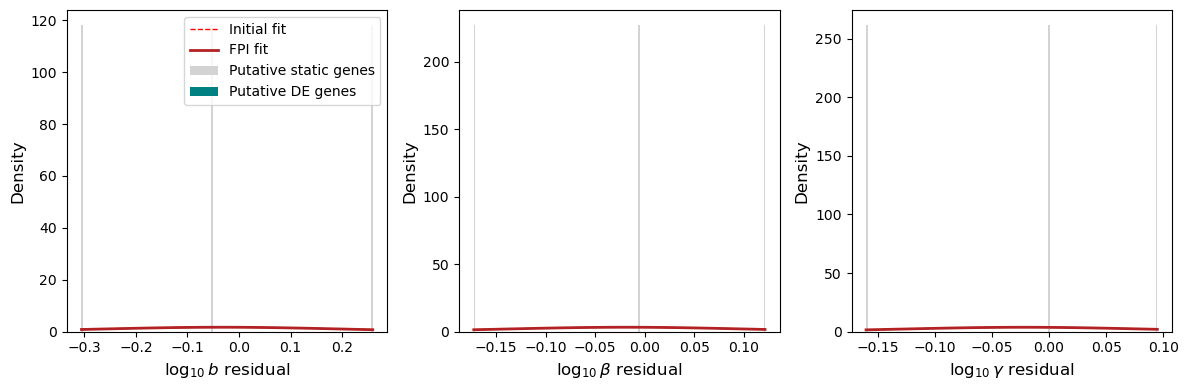

In [21]:
# If 2 anndata objects are given, parameters are compared across datasets.
if not mek_means_params:
    DE_genes, DE_filter, offs, residuals = analysis.DE_parameters(glu_adata, gaba_adata,
                                                              viz=True, use_sigma=True)

# If using meK-Means, compare clusters within one dataset.
else:
    DE_genes_gaba, DE_filter_gaba, offs_gaba, residuals_gaba = analysis.DE_parameters(gaba_adata,
                                                              viz=True, use_sigma=True, discard_rejected=True,
                                                                                     save_cluster_FCs=False)
    clusters = [i for i in DE_genes_gaba.keys()]
    DE_genes = [DE_genes_gaba[i] for i in clusters]
    param_names = gaba_adata.uns['search_result_list'][0].model.get_log_name_str()
    param_num, cluster_num = 0,0
    display(Markdown('E.g.' + param_names[param_num]))
    print(clusters[cluster_num], DE_genes[cluster_num][param_num])

display(gaba_adata.var[[i for i in gaba_adata.var.keys() if 'FC' in i]])

In [ ]:
# # NB changing loom to h5ad.
# adata_gaba = anndata.read_loom('monod_examples/sample_data/allen_C01_gaba.loom')
# adata_gaba.var_names = adata_gaba.var['gene_name']
# adata_gaba.obs_names = adata_gaba.obs['barcode']
# adata_gaba.obs = adata_gaba.obs.drop(columns=['barcode'])
# adata_gaba.var = adata_gaba.var.drop(columns=['gene_name'])
# adata_gaba.write('gaba_example.h5ad')

### Show some gene distributions.

[0 1 2]
Eif5b
Xrcc5
Klhl12


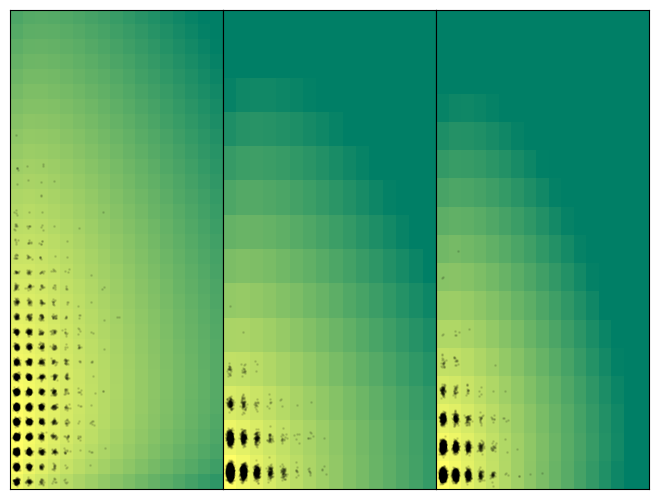

In [22]:
fitted_adata = glu_adata

search_result, search_data = fitted_adata.uns['search_result'], fitted_adata.uns['search_data']
logscale = True

sz =(1,3)
(nrows, ncols) = sz
fig1, ax1 = plt.subplots(nrows=nrows, ncols=ncols)

nax = np.prod(sz)

genes_to_plot = np.arange(nax)

genes_to_plot = np.asarray(genes_to_plot)
if genes_to_plot.dtype == bool:
    gtp_temp = np.arange(self.n_genes)
    genes_to_plot = gtp_temp[genes_to_plot]

number_of_genes_to_plot = len(genes_to_plot)
if number_of_genes_to_plot > 5:
    number_of_genes_to_plot = 5
    genes_to_plot = genes_to_plot[: 5]
if number_of_genes_to_plot > nax:  # This should no longer break...
    number_of_genes_to_plot = nax
    genes_to_plot = genes_to_plot[:nax]

j_ = 0
marg = 'joint'
modalities = ['spliced', 'unspliced']

print(genes_to_plot)
for i_ in genes_to_plot:
    lm = np.copy(search_data.M[:, i_])

    # TODO: generalize by adding attribute names as attribute of e.g. CMEModel
    # attributes = ['unspliced', 'spliced', 'protein']

    num_modalities = 2
    for i in range(num_modalities):
        if marg == modalities[i]:
            lm[:i] = 1
            lm[i+1:]=1

    axloc = np.unravel_index(j_, sz) if (sz[0] > 1 and sz[1] > 1) else j_

    samp = search_result.regressor_optimum[i_]
    Pa = np.squeeze(search_result.model.eval_model_pss(search_result.phys_optimum[i_], lm, samp))
    layers = np.array([i.copy() for i in search_data.layers])

    marg = 'joint'
    if marg == "joint":
        if logscale:
            Pa[Pa < 1e-10] = 1e-10
            Pa = np.log10(Pa)

        if num_modalities==2:
            ax1[axloc].imshow(Pa.T, aspect="auto", cmap="summer")
        elif num_modalities==3:
            ax1[axloc].imshow(Pa.sum(axis=2).T, aspect="auto", cmap="summer")
        else:
            log.error('Joint distribution plot only implemented for 2 or 3 modalities')

        ax1[axloc].invert_yaxis()

        jitter_magn = 0.1
        jitter = np.random.randn(2, search_result.n_cells) * jitter_magn
        ax1[axloc].scatter(
            *layers[:2, :,i_] + jitter, c="k", s=1, alpha=0.1
        )

        ax1[axloc].set_xlim([-0.5, search_data.M[0, i_] - 1.5])
        ax1[axloc].set_ylim([-0.5, search_data.M[1, i_] - 1.5])
    else:
        plot_hist_and_fit(ax1[axloc], search_data, i_, Pa, marg)
        if logscale:
            ax1[axloc].set_yscale("log")

    print(search_result.gene_names[i_])
    # if title:
    #     titlestr = search_result.gene_names[i_]
    #     if hasattr(search_result, "rejected_genes") and search_result.rejected_genes[i_]:
    #         titlestr += " (rej.)"
    #     ax1[axloc].set_title(titlestr, fontdict={"fontsize": 9})
    ax1[axloc].set_xticks([])
    ax1[axloc].set_yticks([])
    j_ += 1
fig1.tight_layout(pad=0.02)


INFO:root:Figure stored to Bursty_Poisson/Bursty_Poisson_6x7/analysis_figures/kldiv.png.
INFO:root:Figure stored to Bursty_Poisson/Bursty_Poisson_6x7/analysis_figures/gene_distributions_joint.png.
INFO:root:P-value threshold: 0.05, Adjusted P-value threshold:0.05, Hellinger Threshold:0.05
INFO:root:Chi-square computation complete. Rejected 2 genes out of 5. Runtime: 0.0 seconds.
INFO:root:Original optimum: -6.20, -1.00.
INFO:root:P-value threshold: 0.05, Adjusted P-value threshold:0.05, Hellinger Threshold:0.05
INFO:root:Chi-square computation complete. Rejected 2 genes out of 5. Runtime: 0.0 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:P-value threshold: 0.05, Adjusted P-value threshold:0.05, Hellinger Threshold:0.05
INFO:root:Chi-square computation complete. Rejected 2 genes out of 5. Runtime: 0.0 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:P-value threshold: 0.05, Adjusted P-value threshold:0.05, Hellinger Threshold:0.05
INFO:root:Chi-square computation comple

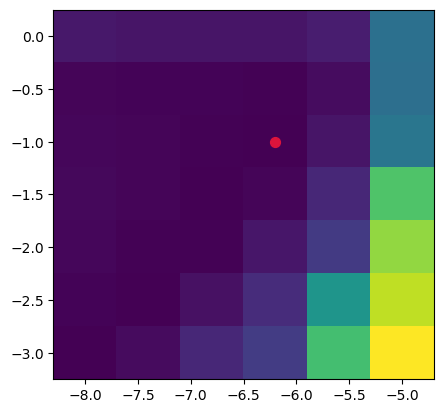

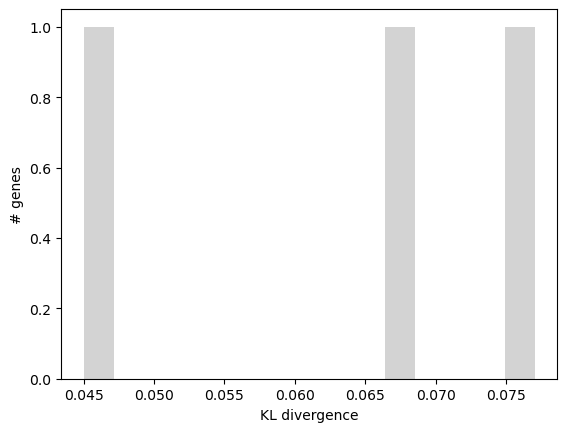

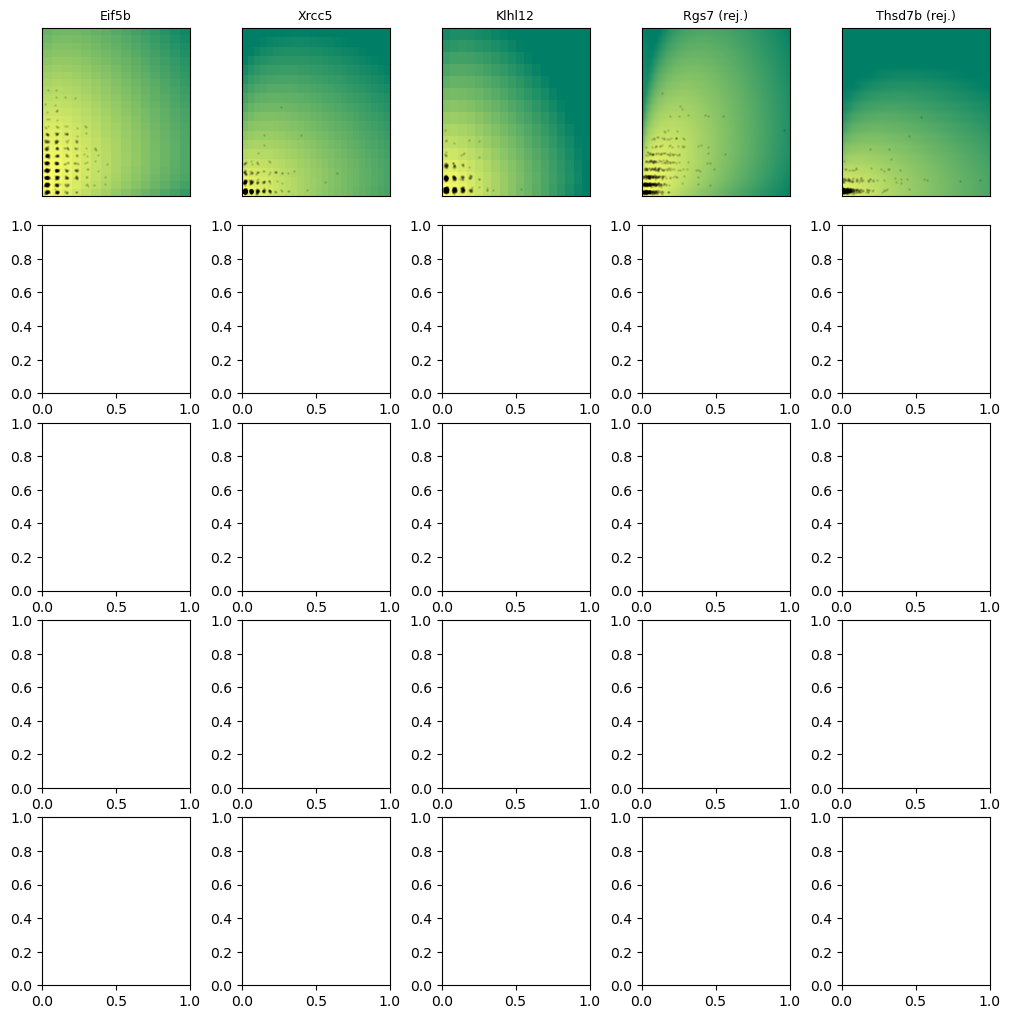

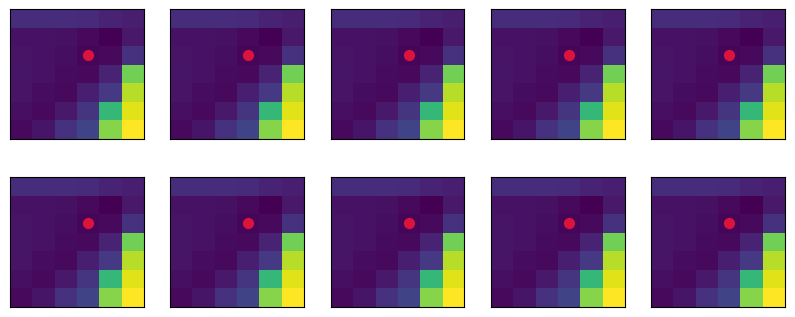

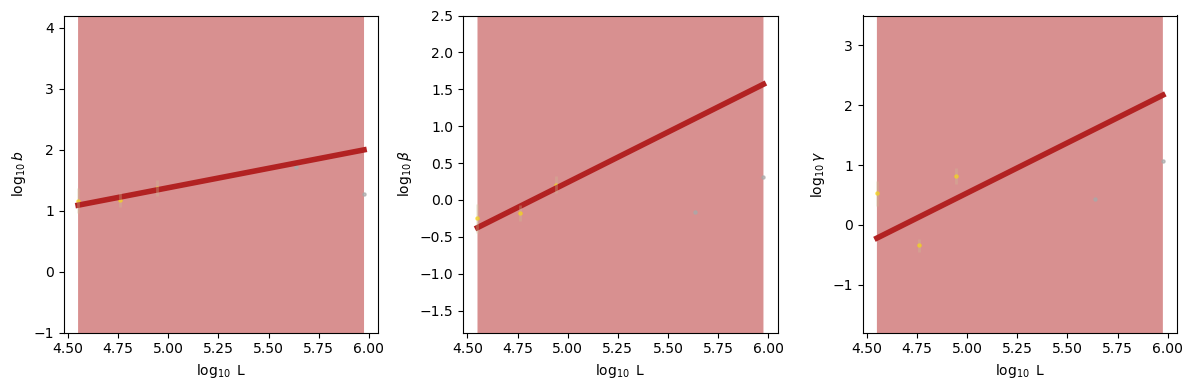

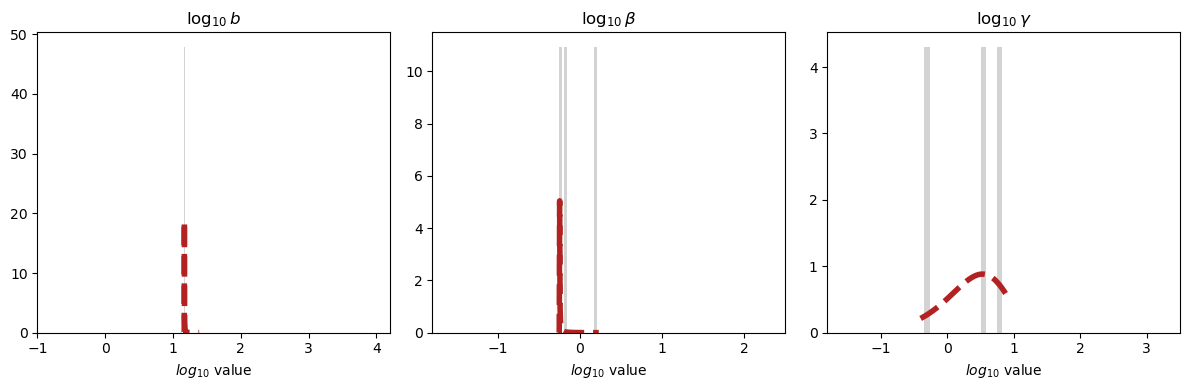

In [23]:
analysis.run_qc(gaba_adata)